In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.modeling import models, fitting
from photutils.aperture import CircularAperture, EllipticalAperture
from photutils.aperture import aperture_photometry

%matplotlib inline
#%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')
plt.rcParams['axes.grid'] = False

In [2]:
# Function to open the fits file and plot them
def Open_Fits(filepath, plot, cmap='gnuplot2'):
    file_temp = fits.open(filepath)
    file = file_temp[0].data
    file_temp.close()
    if plot == True:
        plt.imshow(file, clim=(0, np.quantile(file, [0.99])), cmap=cmap, origin='lower')
        plt.colorbar(fraction=0.0375, pad=0.02);
    return file

# 1) Aperture Photometry

## Filter Ha

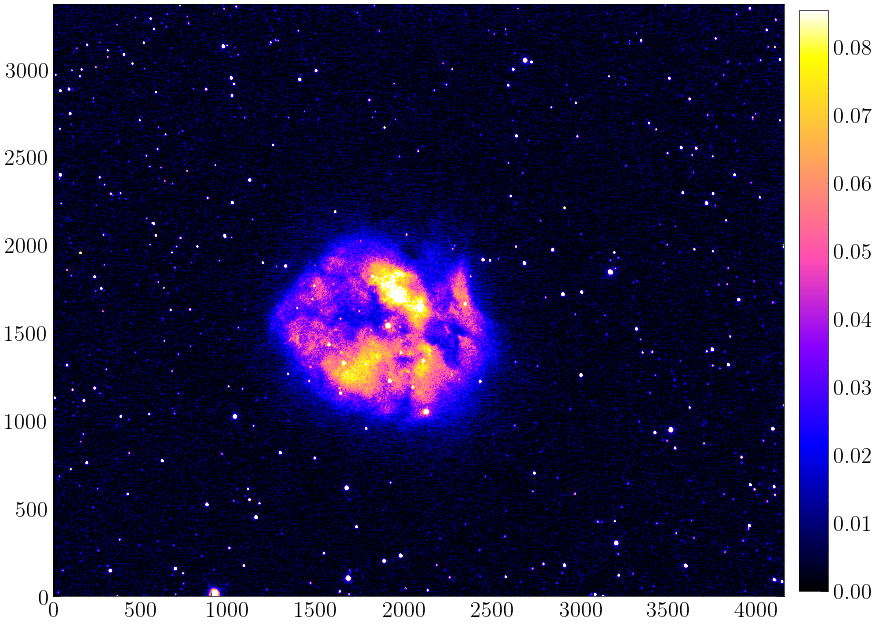

In [3]:
final_Ha = Open_Fits(filepath='Data/final_Ha.fits', plot=True)

In [4]:
final_Ha_radec = fits.open('Data/final_Ha_radec.fits')[1].data
final_Ha_radec

FITS_rec([(328.6532846 , 47.15560772,  921.82434 , 1.74548531e+01, 3.45572052e+01, 0.00260925),
          (328.37017436, 47.26660542, 1907.9147  , 1.53818115e+03, 9.16756153e+00, 0.04750919),
          (328.12018925, 47.38700367, 2686.7764  , 3.04577710e+03, 7.69480991e+00, 0.0024128 ),
          (328.37558545, 47.2012023 , 2125.0745  , 1.04945142e+03, 6.86020613e+00, 0.02323532),
          (328.1420862 , 47.22878445, 3172.8506  , 1.84244763e+03, 6.70983076e+00, 0.00212526),
          (328.16143343, 47.1119084 , 3515.8984  , 9.45524536e+02, 4.97167635e+00, 0.0022378 ),
          (328.39010883, 47.49197238,  970.0183  , 3.12536255e+03, 3.22498703e+00, 0.00243759),
          (328.33571165, 47.44714909, 1404.0621  , 2.93674268e+03, 1.34269893e+00, 0.0023849 ),
          (328.52438474, 47.12269255, 1681.8555  , 1.02863037e+02, 5.45206022e+00, 0.00224209),
          (328.55278954, 47.25886365, 1036.0205  , 1.02124268e+03, 3.96849036e+00, 0.00243831),
          (328.26415876, 47.05925134, 32

In [5]:
print(np.min(final_Ha_radec['ra']), np.max(final_Ha_radec['ra']))
print(np.min(final_Ha_radec['dec']), np.max(final_Ha_radec['dec']))

327.861475729151 328.7958090865958
46.9823001142356 47.5606852155633


In [6]:
# https://vizier.cds.unistra.fr/viz-bin/VizieR-3?-source=I/355/gaiadr3
# Constraints: 327.86 < RA < 328.79     46.98 < DEC < 47.56     12 < Gmag < 17
GAIA_catalogue = fits.open('Data/GAIA_catalogue_12_17.fit')[1].data
GAIA_catalogue

FITS_rec([(328.67847298709, 46.98285794201, 1974523562647578496, 0.0071, 0.0079, 0.5341, 0.0093, 2.806, 1.345, 0.009, -2.463, 0.01, 0.95, 224544.67777, 26.15, 12.30911, 94159.0, 40.88, 12.903883, 186320.0, 36.803, 11.572275, 1.331608, -26.13, 0.78, 0.0, 11.265106, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 5181.7, 2.7894, -0.131, 2119.33, 0.83, 0, 0, 1237671940359323922, 0, '', 'URAT1-685504995', 'J215442.83+465858.3', 12640185, 'N2UQ001008', '', '21544284+4658583', '', 328.67846422597, 46.98286888911),
          (328.67011561284, 46.98342839529, 1974523773108154880, 0.0118, 0.0132, 0.6235, 0.0159, 4.528, -3.928, 0.015, -2.253, 0.017, 0.992, 31600.89923, 5.0581, 14.438118, 15495.0, 14.988, 14.863093, 22894.0, 16.553, 13.848587, 1.014506, -35.18, 4.99, 0.0, 13.466257, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 5796.7, 3.7836, -0.1911, 1744.6805, 0.4729, 0, 164383286701390809, 1237671940359323934, 0, '', 'URAT1-685504944', '', 0, 'N2UQ069781', '', '21544084+4659004', '', 328.67014120556, 46.98343840693),
  

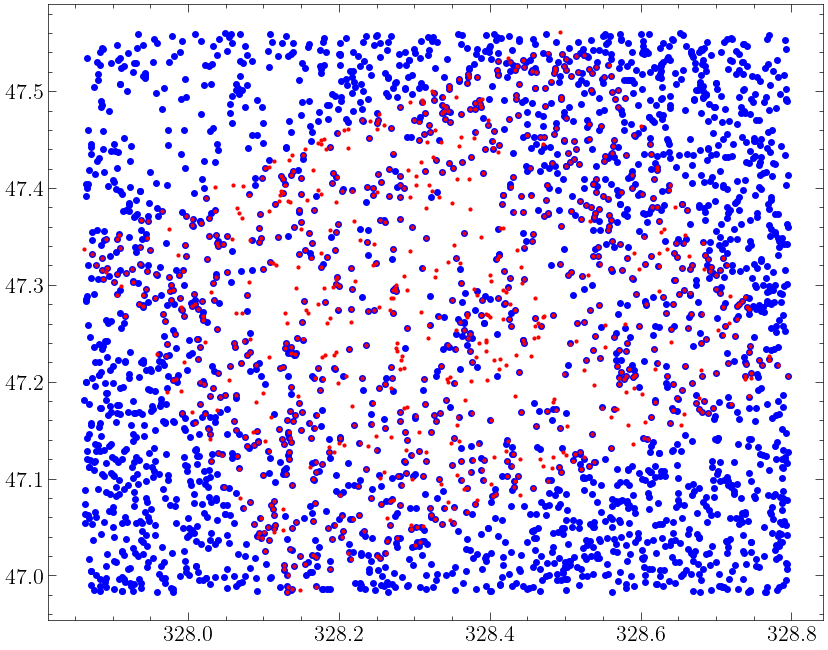

In [7]:
for i in range(len(GAIA_catalogue['RA_ICRS'])):
    plt.plot(GAIA_catalogue['RA_ICRS'][i], GAIA_catalogue['DE_ICRS'][i], c='blue', marker='o', markersize=4)

for i in range(len(final_Ha_radec['ra'])):
    plt.plot(final_Ha_radec['ra'][i], final_Ha_radec['dec'][i], c='red', marker='o', markersize=2)

We are going to perform aperture photometry on 107 stars


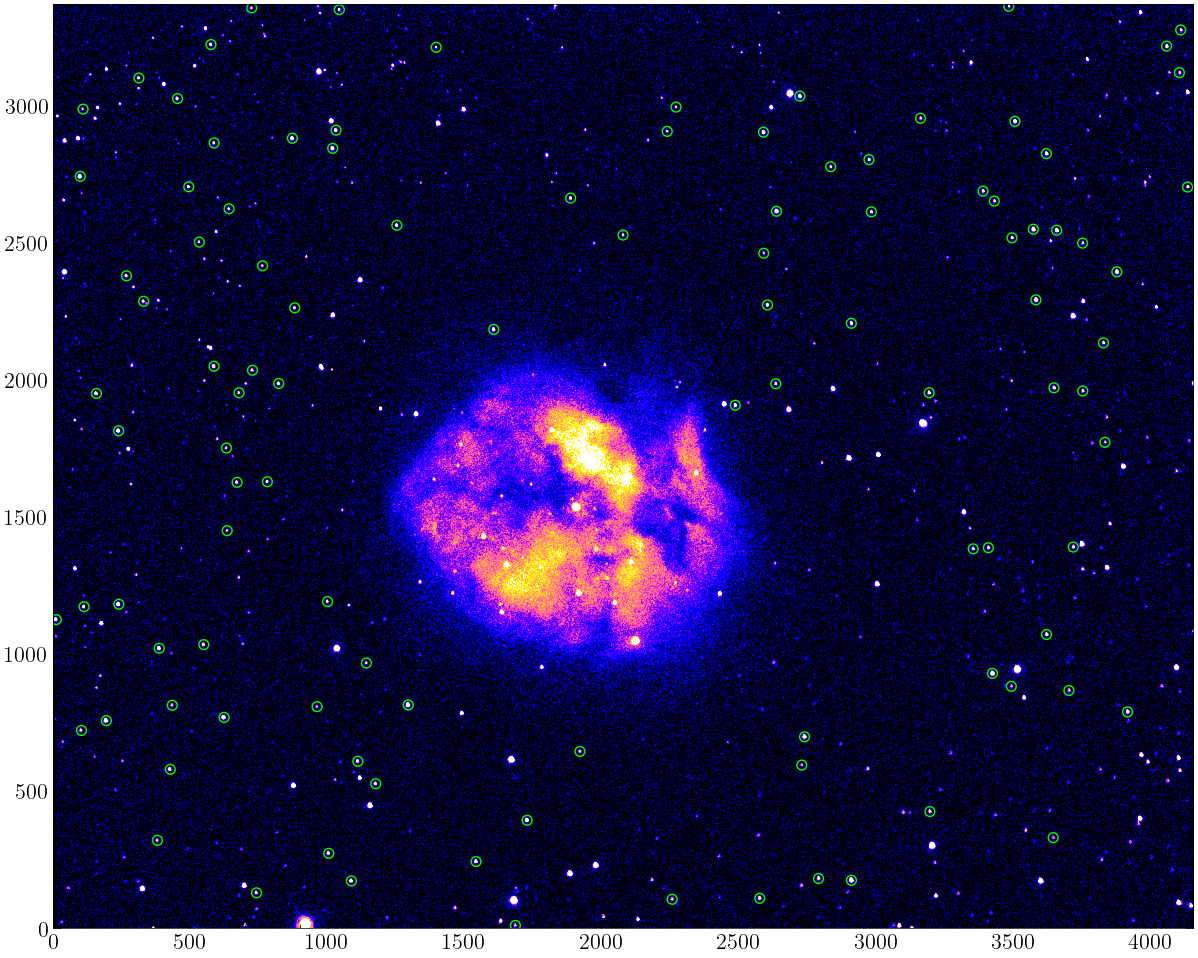

In [8]:
stars_x = []
stars_y = []
stars_mag = []
stars_Gaianame = []
stars_dist = []
stars_ra = []   # useless in this code, but can be used to identify the star at https://skyserver.GAIA.org/dr18/VisualTools/navi/
stars_dec = []  # ...

for i in range(len(GAIA_catalogue['RA_ICRS'])):
    # Ignore the stars in the Gaia catalogue that are too faint or for which we do not have a spectrum
    if (GAIA_catalogue['Gmag'][i] < 14.5) and (GAIA_catalogue['XPsamp'][i] == 1):
        # Ignore the stars in the Gaia catalogue that are too close to the nebula 
        if not ((328.25<GAIA_catalogue['RA_ICRS'][i]<328.5) and (47.2<GAIA_catalogue['DE_ICRS'][i]<47.35)):
            # Ignore the stars in the Gaia catalogue that are too close to another star
            mask_ra = np.isclose(GAIA_catalogue['RA_ICRS'], GAIA_catalogue['RA_ICRS'][i], atol=0, rtol=0.00003)
            mask_dec = np.isclose(GAIA_catalogue['DE_ICRS'], GAIA_catalogue['DE_ICRS'][i], atol=0, rtol=0.00003)
            mask_tot = np.logical_and(mask_ra, mask_dec)

            if np.sum(mask_tot) == 1:
                # Find the matches between GAIA stars and our stars
                # If there is only one match, append the coordinates (from astrometry.net) and magnitudes (from GAIA catalogue)
                # If there is no match or more than one match, do nothing
                mask_ra = np.isclose(final_Ha_radec['ra'], GAIA_catalogue['RA_ICRS'][i], atol=0, rtol=0.0000015)
                mask_dec = np.isclose(final_Ha_radec['dec'], GAIA_catalogue['DE_ICRS'][i], atol=0, rtol=0.0000015)
                mask_tot = np.logical_and(mask_ra, mask_dec)

                if np.sum(mask_tot) == 1:
                    stars_x.append(final_Ha_radec['x'][mask_tot][0])
                    stars_y.append(final_Ha_radec['y'][mask_tot][0])
                    stars_mag.append(GAIA_catalogue['Gmag'][i])
                    stars_Gaianame.append(GAIA_catalogue['Source'][i])
                    stars_dist.append(GAIA_catalogue['Dist'][i])
                    stars_ra.append(GAIA_catalogue['RA_ICRS'][i])
                    stars_dec.append(GAIA_catalogue['DE_ICRS'][i])
        
stars_x = np.array(stars_x)
stars_y = np.array(stars_y)
stars_mag = np.array(stars_mag)
stars_Gaianame = np.array(stars_Gaianame)
stars_dist = np.array(stars_dist)
stars_ra = np.array(stars_ra)
stars_dec = np.array(stars_dec)
        
plt.figure(figsize=(18,12))
plt.imshow(final_Ha, clim=(0, np.quantile(final_Ha, [0.99])), cmap='gnuplot2', origin='lower')

for i in range(len(stars_x)):
    plt.scatter(stars_x[i], stars_y[i], facecolors='none', edgecolors='lime', s=50)
    
print(f'We are going to perform aperture photometry on {len(stars_Gaianame)} stars')

In [9]:
# Sort the star arrays by source_Id (fundamental to match the list of spectra downloaded from GAIA servers)
sort_indices = np.argsort(stars_Gaianame)
stars_x = stars_x[sort_indices]
stars_y = stars_y[sort_indices]
stars_mag = stars_mag[sort_indices]
stars_Gaianame = stars_Gaianame[sort_indices]
stars_dist = stars_dist[sort_indices]
stars_ra = stars_ra[sort_indices]
stars_dec = stars_dec[sort_indices]

In [10]:
# Remove some stars
name_discard = [# Some stars at the boundaries return an error when trying to fit a Gaussian to them
                1974529133227291904, 1976044913085754496, 
                # We also remove some stars that are much fainter than they should be
                1974536554930468352, 1974540162703148416, 1974735291654994304, 1976043813574043008, 1976048383419123712, 1976236571705944960]
index_discard = []
for val in name_discard:
    index_discard.append(np.where(stars_Gaianame==val)[0][0])
    
stars_x = np.delete(stars_x, index_discard)
stars_y = np.delete(stars_y, index_discard)
stars_mag = np.delete(stars_mag, index_discard)
stars_Gaianame = np.delete(stars_Gaianame, index_discard)
stars_dist = np.delete(stars_dist, index_discard)
stars_ra = np.delete(stars_ra, index_discard)
stars_dec = np.delete(stars_dec, index_discard)

In [11]:
def Aperture_Photometry(image, stars_x, stars_y, stars_Gaianame, stars_ra, stars_dec, stars_mag, exposure_time, plot=False, rectangle_side=40, fwhm_factor=3):
    
    # We also compute the error on the electron counts, for each pixel
    # Probably we should do this before removing the average background, indeed here we have some pixels with negative values
    image_err = np.sqrt(np.abs(image)*exposure_time)/exposure_time
    
    N = len(stars_x)
    ourfluxes = []
    ourfluxes_err = []

    fig, ax = plt.subplots(figsize=(18,12))
    ax.imshow(image, clim=(0, np.quantile(image, [0.99])), cmap='gnuplot2', origin='lower')
    
    
    if plot==True:
        if N % 8 == 0:
            fig_2, axes_2 = plt.subplots(int(N/8), 8, figsize=(24, 4*int(N/8)))
        else:
            fig_2, axes_2 = plt.subplots(int(N/8)+1, 8, figsize=(24, 4*(int(N/8)+1)))


    for i in range(N):
        cutout = image[round(stars_y[i]-rectangle_side/2):round(stars_y[i]+rectangle_side/2), round(stars_x[i]-rectangle_side/2):round(stars_x[i]+rectangle_side/2)]

        # 1) Compute the FWHM of the stars to decide the radius of the circular aperture   
        y, x = np.mgrid[:cutout.shape[0], :cutout.shape[1]]
        gaussian_init = models.Gaussian2D(amplitude=np.max(cutout), 
                                          x_mean=cutout.shape[0]/2, 
                                          y_mean=cutout.shape[1]/2, 
                                          x_stddev=cutout.shape[0]/5, 
                                          y_stddev=cutout.shape[1]/5)
        gaussian_fit = fitting.LevMarLSQFitter()
        fitted_gaussian = gaussian_fit(gaussian_init, x, y, cutout)
        mean_x = fitted_gaussian.x_mean.value
        fwhm_x = 2.355*fitted_gaussian.x_stddev.value
        mean_y = fitted_gaussian.y_mean.value
        fwhm_y = 2.355*fitted_gaussian.y_stddev.value
        
            
        # 2) Redefine the centroid and define the aperture radius
        # the cutout frame, in which mean_x and mean_y are defined, is centered on the left-bottom corner of the rectangle
        aperture_centroid = [round(stars_x[i]-rectangle_side/2)+mean_x, round(stars_y[i]-rectangle_side/2)+mean_y]
        # the aperture radius is a radius, and thus we must divide the FWHM by 2!
        aperture_r = fwhm_factor*np.mean([fwhm_x/2, fwhm_y/2])
        
        
        # 3) Compute the flux of the star
        aperture = CircularAperture(aperture_centroid, r=aperture_r)
        ourfluxes.append(aperture_photometry(image, aperture)['aperture_sum'][0])
        
        
        # 4) Compute the error on the flux of the star, according to standard error propagation (root of the sum of the squares of the errors in the individual pixels)
        ourfluxes_err.append(np.sqrt(aperture_photometry(image_err**2, aperture)['aperture_sum'][0]))
        
        
        # 5) Plot the resulting apertures on the image
        circle_plot = plt.Circle(aperture_centroid, aperture_r, color='lime', linewidth=0.8, fill=False)
        ax.add_patch(circle_plot)
        ax.text(aperture_centroid[0]+1.5*aperture_r, aperture_centroid[1]-0.8*aperture_r, f'{i}', fontsize=15, color='lime')
        
        
        # 6) Plot the cutouts
        if plot==True:
            ax_2 = axes_2.flatten()[i]
            ax_2.set_title(f'Star {i}: {stars_Gaianame[i]} \n RA={stars_ra[i]:.4f} , DEC={stars_dec[i]:.4f} \n  GAIA_mag={stars_mag[i]:.2f} \n $e/s={ourfluxes[i]:.2f} \pm {ourfluxes_err[i]:.2f}$', fontsize=11)
            ax_2.imshow(cutout, clim=(0, np.quantile(cutout, [0.99])), cmap='gnuplot2', origin='lower')
            circle_plot = plt.Circle([mean_x, mean_y], aperture_r, color='lime', linewidth=1.5, fill=False)
            ax_2.add_patch(circle_plot)
        
            # Remove the unused axes (actually, it does not work)
            for i in range(N % 8):
                axes_2.flatten()[-1-i].axis('off')
    
    return np.array(ourfluxes), np.array(ourfluxes_err)

\# Elliptic aperture: disappointing results
from matplotlib.patches import Ellipse

def Aperture_Photometry(image, stars_x, stars_y, stars_Gaianame, stars_ra, stars_dec, stars_mag, rectangle_side=40, fwhm_factor=3):
    ourfluxes = []

    fig, ax = plt.subplots(figsize=(18,12))
    ax.imshow(image, clim=(0, np.quantile(image, [0.99])), cmap='gnuplot2', origin='lower')
    
    N = len(stars_x)
    if N % 8 == 0:
        fig_2, axes_2 = plt.subplots(int(N/8), 8, figsize=(24, 4*int(N/8)))
    else:
        fig_2, axes_2 = plt.subplots(int(N/8)+1, 8, figsize=(24, 4*(int(N/8)+1)))


    for i in range(N):
        cutout = image[round(stars_y[i]-rectangle_side/2):round(stars_y[i]+rectangle_side/2), round(stars_x[i]-rectangle_side/2):round(stars_x[i]+rectangle_side/2)]

        # 1) Compute the FWHM of the stars to decide the radius of the circular aperture   
        y, x = np.mgrid[:cutout.shape[0], :cutout.shape[1]]
        gaussian_init = models.Gaussian2D(amplitude=np.max(cutout), 
                                          x_mean=cutout.shape[0]/2, 
                                          y_mean=cutout.shape[1]/2, 
                                          x_stddev=cutout.shape[0]/5, 
                                          y_stddev=cutout.shape[1]/5)
        gaussian_fit = fitting.LevMarLSQFitter()
        fitted_gaussian = gaussian_fit(gaussian_init, x, y, cutout)
        mean_x = fitted_gaussian.x_mean.value
        fwhm_x = 2.355*fitted_gaussian.x_stddev.value
        mean_y = fitted_gaussian.y_mean.value
        fwhm_y = 2.355*fitted_gaussian.y_stddev.value
        
            
        # 2) Redefine the centroid and define the aperture radius
        # the cutout frame, in which mean_x and mean_y are defined, is centered on the left-bottom corner of the rectangle
        aperture_centroid = [round(stars_x[i]-rectangle_side/2)+mean_x, round(stars_y[i]-rectangle_side/2)+mean_y]
        # the size of an elliptical aperture is defined by semi-axes, and thus we must divide the FWHM by 2!
        aperture_r = fwhm_factor*np.mean([fwhm_x/2, fwhm_y/2])
        aperture_a = fwhm_factor*fwhm_x/2
        aperture_b = fwhm_factor*fwhm_y/2
        
        
        # 3) Compute the flux of the stars
        #aperture = CircularAperture(aperture_centroid, r=aperture_r)
        aperture = EllipticalAperture(aperture_centroid, a=2*aperture_a, b=2*aperture_b, theta=0)
        ourfluxes.append(aperture_photometry(image, aperture)['aperture_sum'][0])
        
        
        # 4) Plot the resulting apertures on the image
        ellipse_plot = Ellipse(xy=aperture_centroid, width=aperture_a, height=aperture_b, angle=0, color='lime', linewidth=0.8, fill=False)
        ax.add_patch(ellipse_plot)
        ax.text(aperture_centroid[0]+1.5*aperture_a, aperture_centroid[1]-0.8*aperture_a, f'{i}', fontsize=15, color='lime')
        
        
        # 5) Plot the cutouts
        ax_2 = axes_2.flatten()[i]
        ax_2.set_title(f'Star {i}: {stars_Gaianame[i]} \n RA={stars_ra[i]:.4f} , DEC={stars_dec[i]:.4f} \n  GAIA_mag={stars_mag[i]:.2f} , e/s={ourfluxes[i]:.2f}', fontsize=11)
        ax_2.imshow(cutout, clim=(0, np.quantile(cutout, [0.99])), cmap='gnuplot2', origin='lower')
        ellipse_plot = Ellipse(xy=[mean_x, mean_y], width=2*aperture_a, height=2*aperture_b, angle=0, color='lime', linewidth=1.5, fill=False)
        ax_2.add_patch(ellipse_plot)
        
    
    # Remove the unused axes (actually, it does not work...)
    for i in range(N % 8):
        axes_2.flatten()[-1-i].axis('off')
    
    return np.array(ourfluxes)

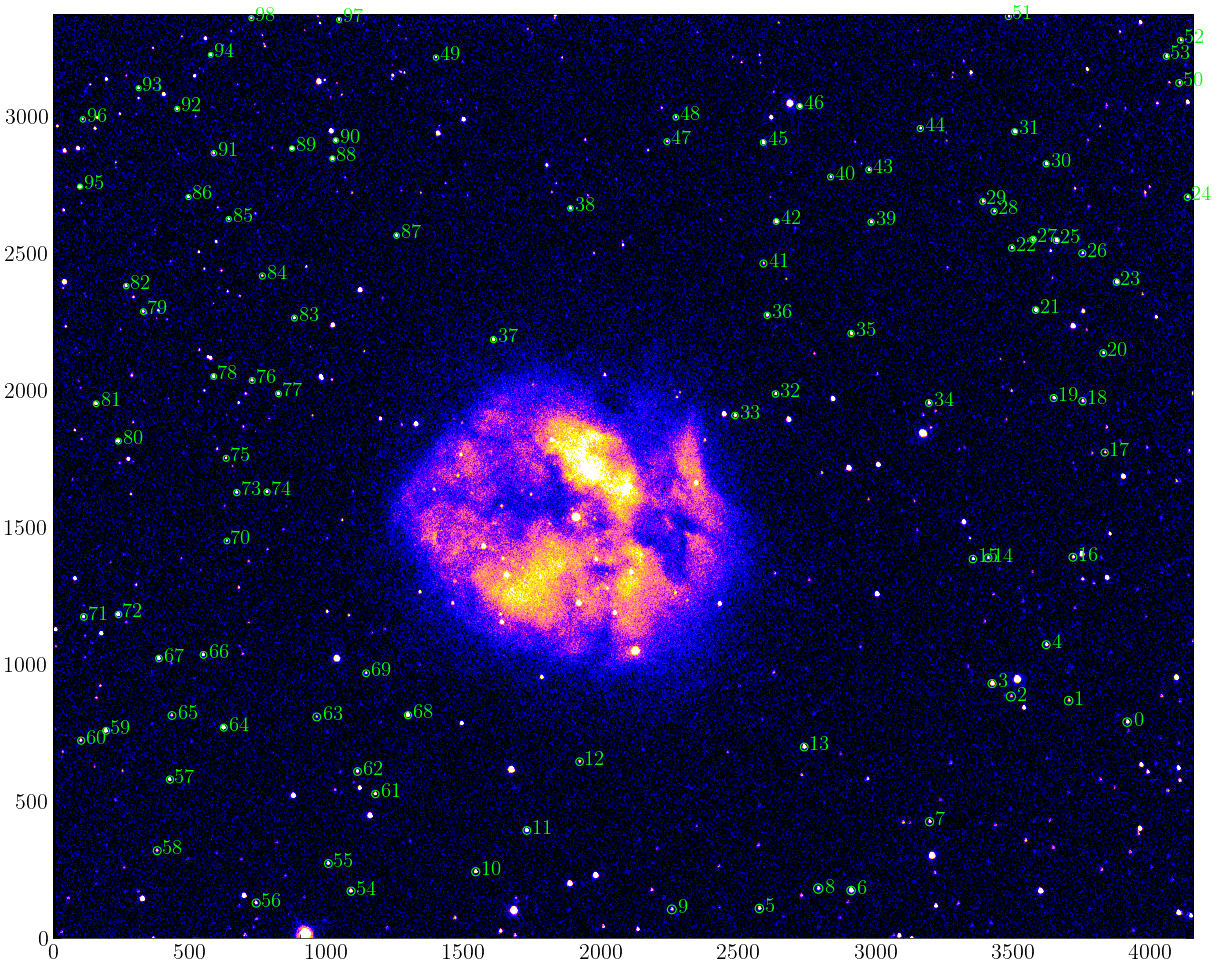

In [12]:
ourfluxes_Ha, ourfluxes_Ha_err = Aperture_Photometry(final_Ha, stars_x, stars_y, stars_Gaianame, stars_ra, stars_dec, stars_mag, exposure_time=300)

## Filter Hb

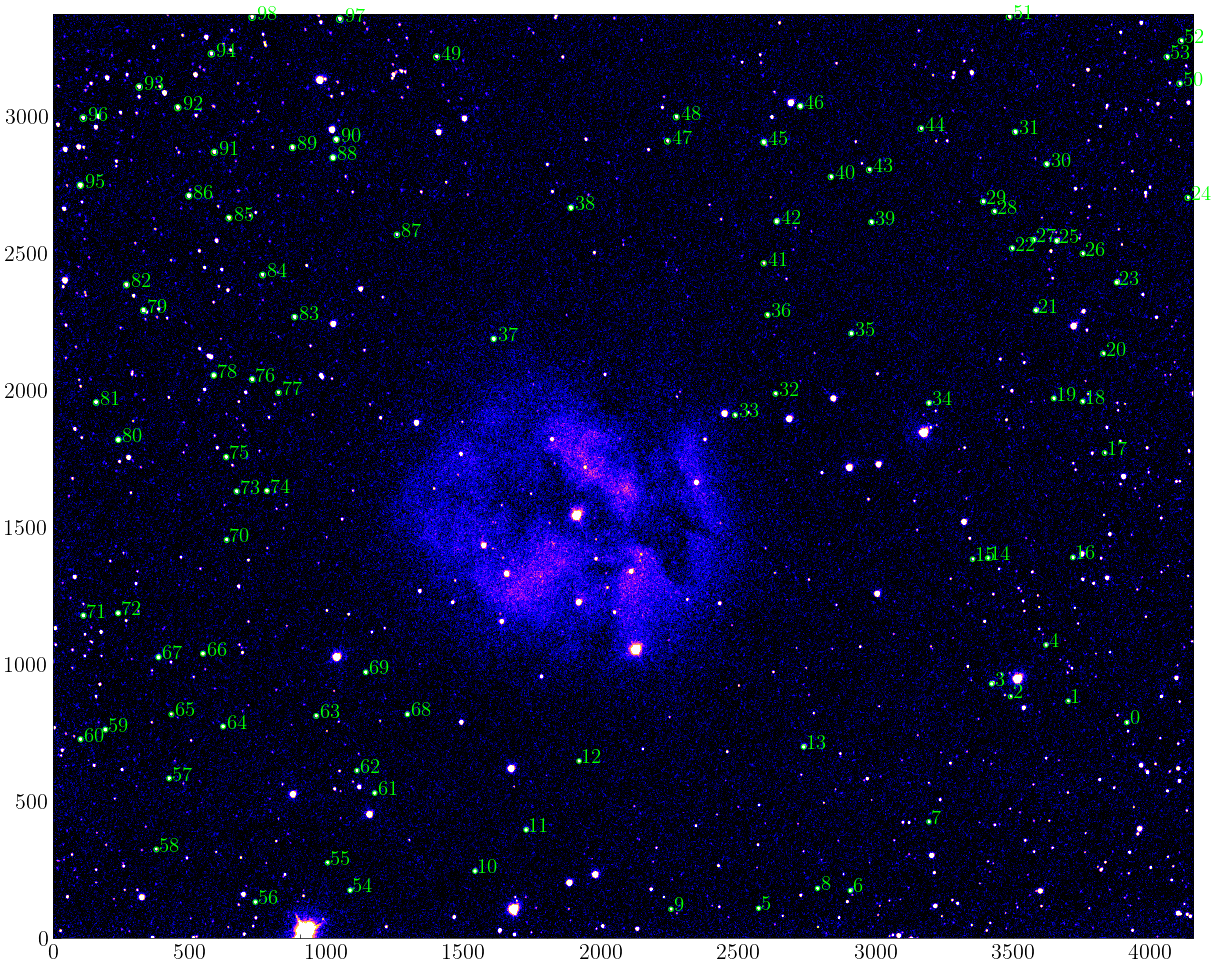

In [13]:
final_Hb = Open_Fits(filepath='Data/final_Hb.fits', plot=False)

ourfluxes_Hb, ourfluxes_Hb_err = Aperture_Photometry(final_Hb, stars_x, stars_y, stars_Gaianame, stars_ra, stars_dec, stars_mag, exposure_time=1200)

## Filter g

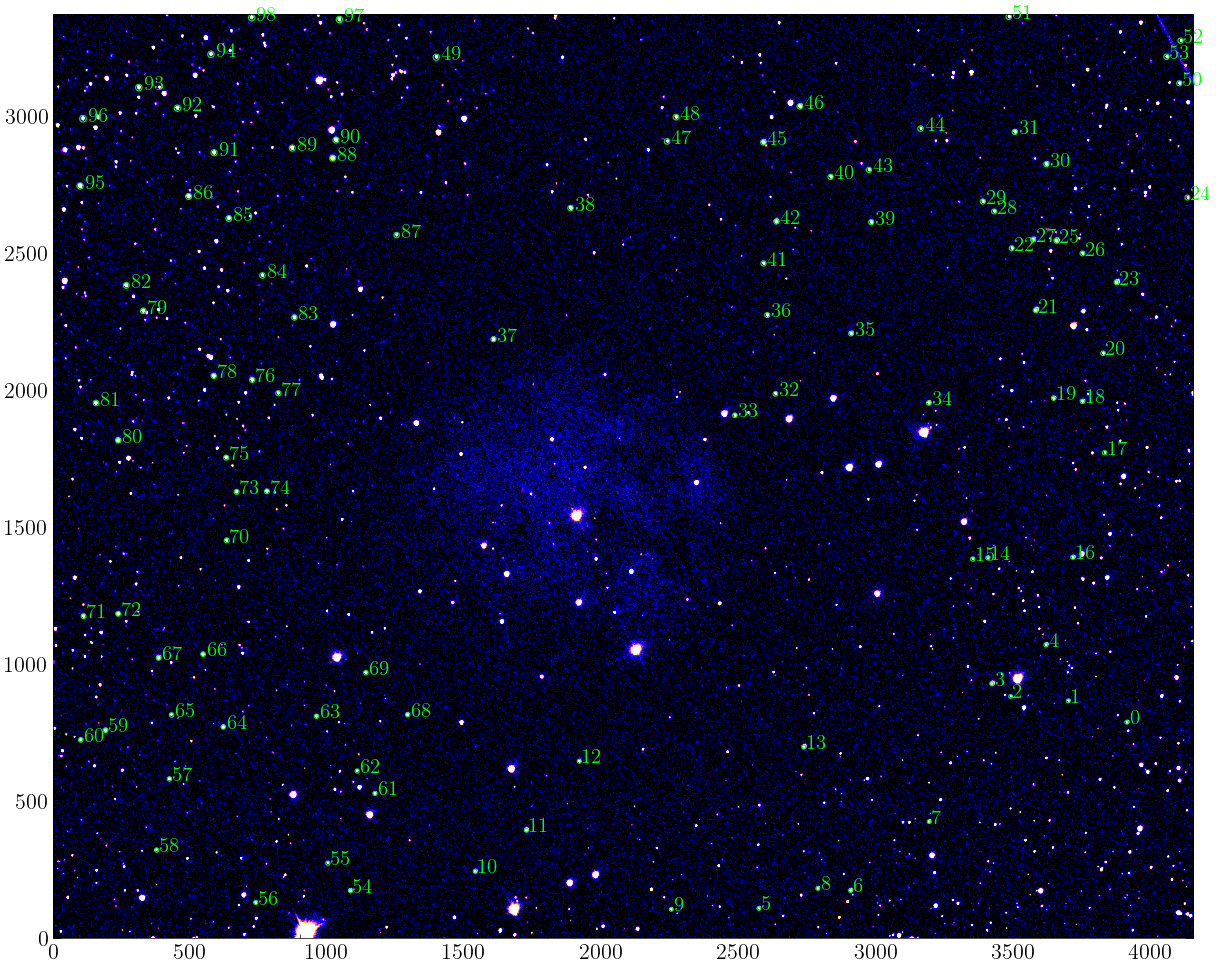

In [14]:
final_g = Open_Fits(filepath='Data/final_g.fits', plot=False)

ourfluxes_g, ourfluxes_g_err = Aperture_Photometry(final_g, stars_x, stars_y, stars_Gaianame, stars_ra, stars_dec, stars_mag, exposure_time=120)

## Filter r

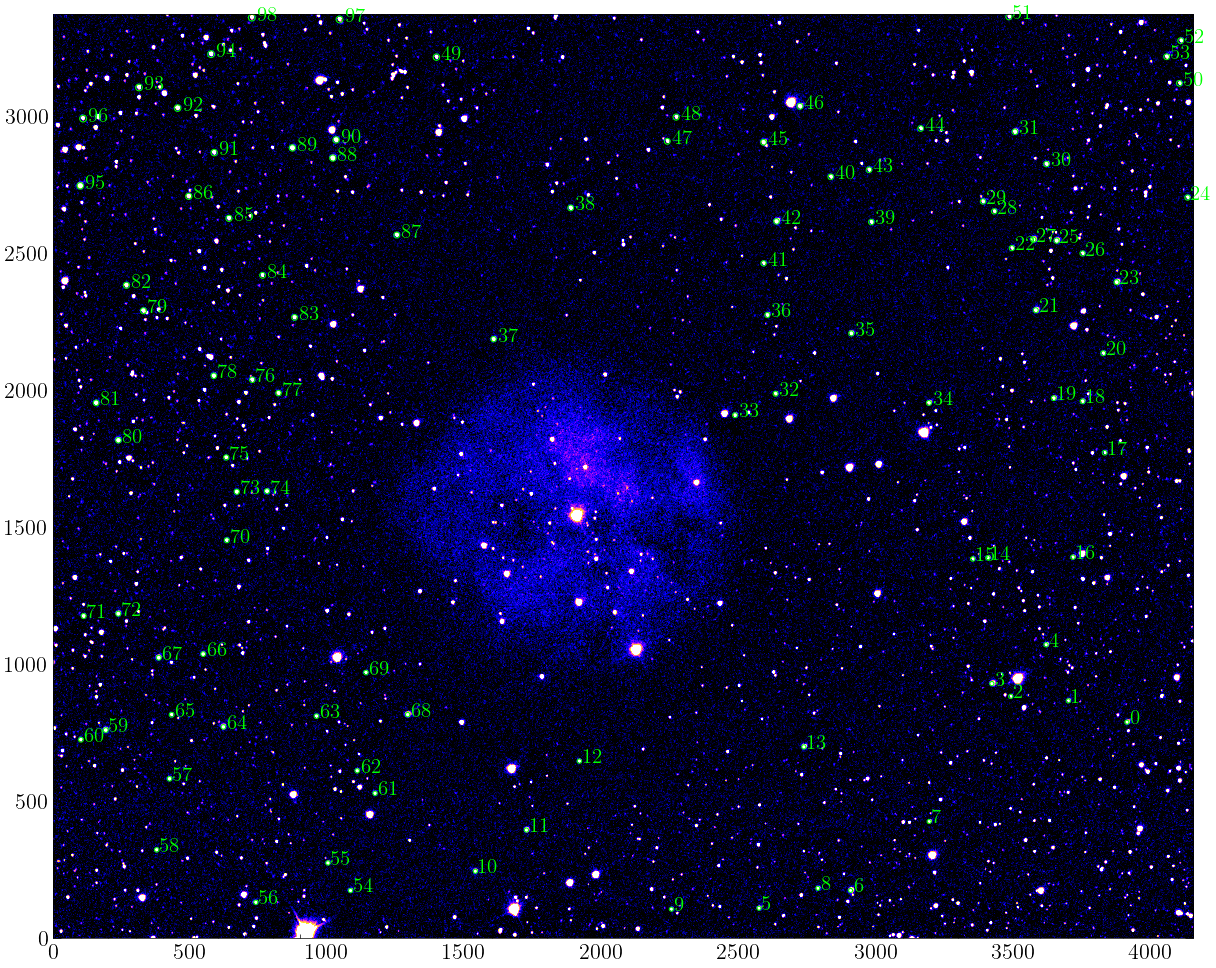

In [15]:
final_r = Open_Fits(filepath='Data/final_r.fits', plot=False)

ourfluxes_r, ourfluxes_r_err = Aperture_Photometry(final_r, stars_x, stars_y, stars_Gaianame, stars_ra, stars_dec, stars_mag, exposure_time=120)

## Filter i

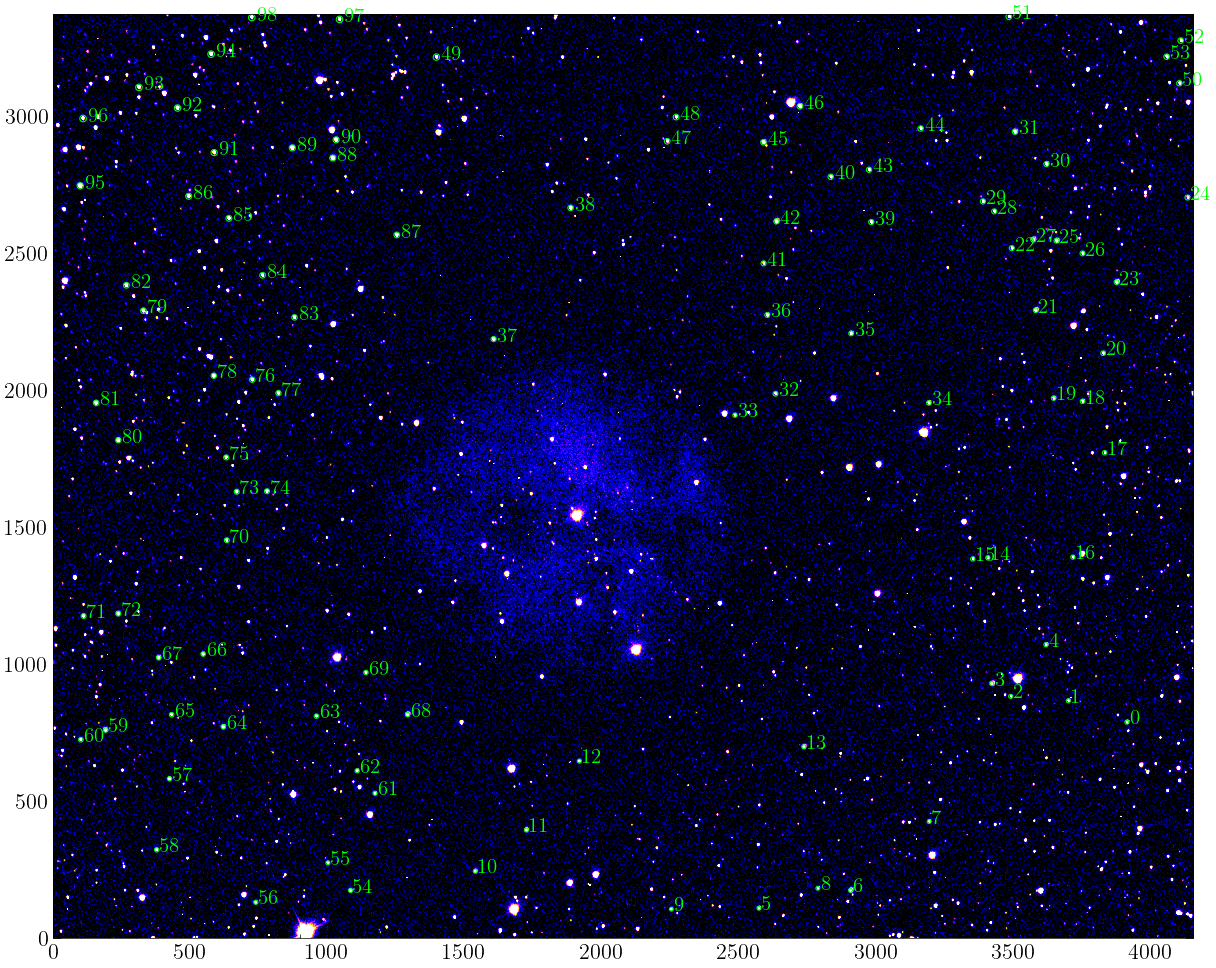

In [16]:
final_i = Open_Fits(filepath='Data/final_i.fits', plot=False)

ourfluxes_i, ourfluxes_i_err = Aperture_Photometry(final_i, stars_x, stars_y, stars_Gaianame, stars_ra, stars_dec, stars_mag, exposure_time=120)

# 2) Download Gaia spectra

In [17]:
# https://www.cosmos.esa.int/web/gaia-users/archive/datalink-products
#!pip install astroquery
from astroquery.gaia import Gaia

retrieval_type = 'XP_SAMPLED'     # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
data_structure = 'INDIVIDUAL'     # Options are: 'INDIVIDUAL' or 'RAW'
data_release   = 'Gaia DR3'       # Options are: 'Gaia DR3' (default), 'Gaia DR2'
datalink = Gaia.load_data(ids=stars_Gaianame,
                          data_release=data_release, retrieval_type=retrieval_type, data_structure=data_structure, format='votable', verbose=True, output_file='Spectra/Gaia_spectra', overwrite_output_file='True')

dl_keys  = [inp for inp in datalink.keys()]

print()
print(f'The following Datalink products have been downloaded:')
for dl_key in dl_keys:
    print(f' * {dl_key}')

"ltr" dir="ltr" lang="en-GB">

Archive down for maintenance
"X-UA-Compatible" content="IE=edge" />

"UTF-8" />

Archive down for maintenance
"initial-scale=1.0, width=device-width" name="viewport" />

"Cache-Control" content="no-cache, no-store, must-revalidate">

"Pragma" content="no-cache">

"Expires" content="0">

"refresh" content="60" /> -->

"icon"

"https://www.cosmos.esa.int/o/CosmosTheme-theme/images/favicon.ico" />

Archive down for maintenance
"apple-touch-icon-precomposed"

"https://www.cosmos.esa.int/o/CosmosTheme-theme/images/apple-touch-icon-precomposed.png" />

Archive down for maintenance
Archive down for maintenance
"apple-touch-icon-precomposed" sizes="72x72"

"https://www.cosmos.esa.int/o/CosmosTheme-theme/images/apple-touch-icon-72x72-precomposed.png" />

Archive down for maintenance
"apple-touch-icon-precomposed" sizes="76x76"

"https://www.cosmos.esa.int/o/CosmosTheme-theme/images/apple-touch-icon-76x76-precomposed.png" />

Archive down for maintenance
"apple-tou

ERROR: Path d:\OneDrive - Università degli Studi di Milano-Bicocca\Documenti\PythonProjects\Laboratory-of-Data-Acquisition\Spectra already exist [astroquery.gaia.core]


host = gea.esac.esa.int:443
context = /data-server/data
Content-type = application/x-www-form-urlencoded
200 OK
Reading...
Done.
INFO: output_file = d:\OneDrive - Università degli Studi di Milano-Bicocca\Documenti\PythonProjects\Laboratory-of-Data-Acquisition\Spectra\Gaia_spectra.zip [astroquery.gaia.core]

The following Datalink products have been downloaded:
 * XP_SAMPLED-Gaia DR3 1974537310844693120.xml
 * XP_SAMPLED-Gaia DR3 1974537688801813120.xml
 * XP_SAMPLED-Gaia DR3 1974537753221355392.xml
 * XP_SAMPLED-Gaia DR3 1974537856298735104.xml
 * XP_SAMPLED-Gaia DR3 1974537998039452416.xml
 * XP_SAMPLED-Gaia DR3 1974539131911015552.xml
 * XP_SAMPLED-Gaia DR3 1974539436846701056.xml
 * XP_SAMPLED-Gaia DR3 1974539647307075712.xml
 * XP_SAMPLED-Gaia DR3 1974539819105777792.xml
 * XP_SAMPLED-Gaia DR3 1974540437581209984.xml
 * XP_SAMPLED-Gaia DR3 1974541056056499584.xml
 * XP_SAMPLED-Gaia DR3 1974541223553094400.xml
 * XP_SAMPLED-Gaia DR3 1974541708891518208.xml
 * XP_SAMPLED-Gaia DR3 197

In [18]:
wavelengths = datalink[dl_keys[1]][0].to_table().as_array()['wavelength']
wavelengths = np.ma.getdata(wavelengths)
wavelengths

array([ 336.,  338.,  340.,  342.,  344.,  346.,  348.,  350.,  352.,
        354.,  356.,  358.,  360.,  362.,  364.,  366.,  368.,  370.,
        372.,  374.,  376.,  378.,  380.,  382.,  384.,  386.,  388.,
        390.,  392.,  394.,  396.,  398.,  400.,  402.,  404.,  406.,
        408.,  410.,  412.,  414.,  416.,  418.,  420.,  422.,  424.,
        426.,  428.,  430.,  432.,  434.,  436.,  438.,  440.,  442.,
        444.,  446.,  448.,  450.,  452.,  454.,  456.,  458.,  460.,
        462.,  464.,  466.,  468.,  470.,  472.,  474.,  476.,  478.,
        480.,  482.,  484.,  486.,  488.,  490.,  492.,  494.,  496.,
        498.,  500.,  502.,  504.,  506.,  508.,  510.,  512.,  514.,
        516.,  518.,  520.,  522.,  524.,  526.,  528.,  530.,  532.,
        534.,  536.,  538.,  540.,  542.,  544.,  546.,  548.,  550.,
        552.,  554.,  556.,  558.,  560.,  562.,  564.,  566.,  568.,
        570.,  572.,  574.,  576.,  578.,  580.,  582.,  584.,  586.,
        588.,  590.,

In [19]:
fluxes = datalink[dl_keys[1]][0].to_table().as_array()['flux']
fluxes = np.ma.getdata(fluxes)
fluxes

array([2.4730320e-17, 2.4072203e-17, 2.2341364e-17, 1.9495348e-17,
       1.8313772e-17, 1.9579598e-17, 2.1215381e-17, 2.0566494e-17,
       1.9142258e-17, 2.0364874e-17, 2.3408482e-17, 2.4342837e-17,
       2.2885257e-17, 2.0092546e-17, 1.8631156e-17, 2.0494839e-17,
       2.4757789e-17, 2.7603813e-17, 2.6095034e-17, 2.1401070e-17,
       1.7819011e-17, 1.8923292e-17, 2.2930466e-17, 2.4442216e-17,
       2.1327310e-17, 1.7081544e-17, 1.5939468e-17, 1.8011133e-17,
       2.0655689e-17, 2.2050063e-17, 2.2784885e-17, 2.4486814e-17,
       2.7831941e-17, 3.2051925e-17, 3.5303830e-17, 3.6602014e-17,
       3.6254039e-17, 3.5461153e-17, 3.5373879e-17, 3.6467617e-17,
       3.8004608e-17, 3.9054539e-17, 3.8982610e-17, 3.7786047e-17,
       3.6014875e-17, 3.4427528e-17, 3.3417207e-17, 3.3260506e-17,
       3.3904889e-17, 3.5185087e-17, 3.7006099e-17, 3.9220133e-17,
       4.1413003e-17, 4.3313804e-17, 4.4724729e-17, 4.5655953e-17,
       4.6273645e-17, 4.6806190e-17, 4.7482090e-17, 4.8352753e

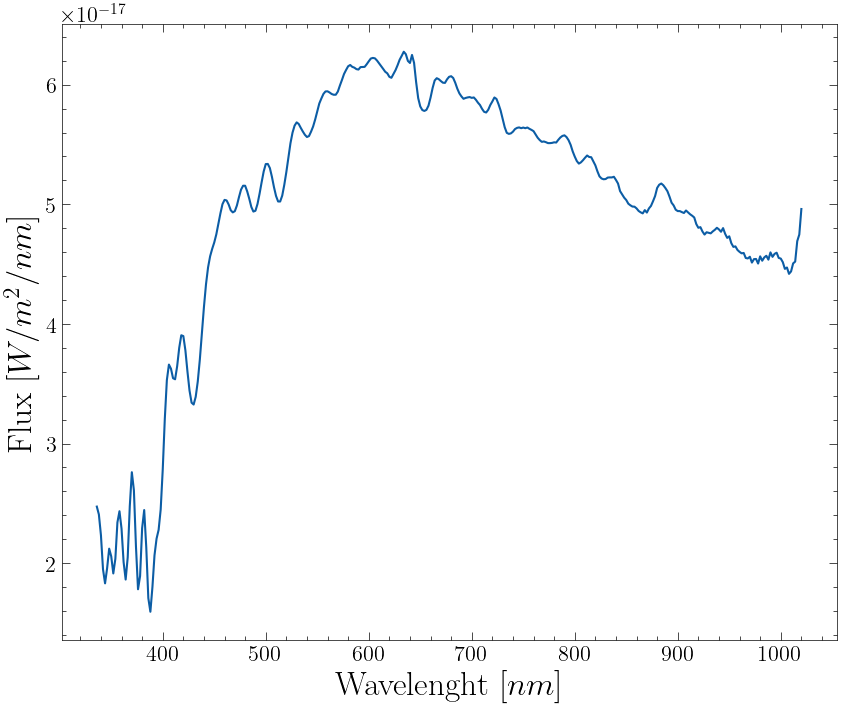

In [20]:
plt.plot(wavelengths, fluxes)
plt.xlabel('Wavelenght $[nm]$')
plt.ylabel('Flux $[W / m^2 / nm]$');

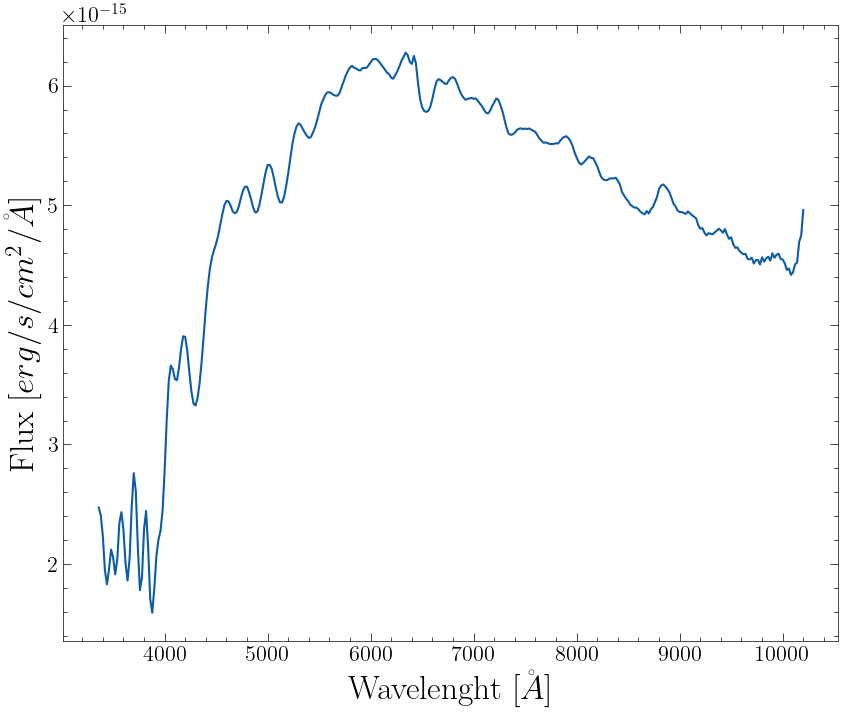

In [21]:
plt.plot(10*wavelengths, (10**2)*fluxes) 
plt.xlabel('Wavelenght $[\AA]$')
plt.ylabel('Flux $[erg / s / cm^2 / \AA]$');

# 3) Average Gaia spectra over TOBi filters

- $m_\text{true} = \text{ZP} + m_\text{instrument}$

- $-2.5 \log_{10} f_\lambda = \text{ZP} - 2.5 \log_{10} R[e^-/s]$

- $f_\lambda [erg/s/cm^2/\AA] = 10^{-0.4 \text{ZP}} R[e^-/s] \doteq 10^{-C} R[e^-/s]$ 

- $R[e^-/s] = 10^C f_\lambda [erg/s/cm^2/\AA]$

We want to fit the $R[e^-/s]$ from our data as a function of the $f_\lambda [erg/s/cm^2/\AA]$ provided by Gaia, finding $C$.\
Then, we can use this estimate of $C$ to convert our data from $R[e^-/s]$ to $f_\lambda [erg/s/cm^2/\AA]$.

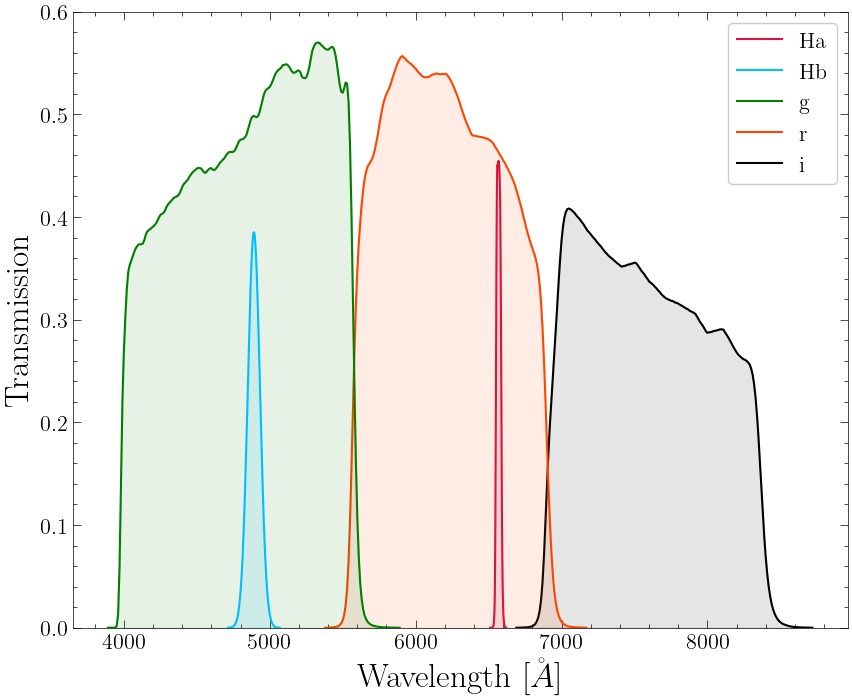

In [22]:
# Let us extract and plot the filters

filter_names = ['Ha', 'Hb', 'g', 'r', 'i']

# Corresponding file paths
file_paths = ['Filters/tobi_ha.dat',
              'Filters/tobi_hb.dat',
              'Filters/tobi_gsdss.dat',
              'Filters/tobi_rsdss.dat',
              'Filters/tobi_isdss.dat']

filter_transmission = {}

for filter_name, file_path in zip(filter_names, file_paths):
    data = np.loadtxt(file_path)
    x = data[:, 0]  
    y = data[:, 1]  
    # Store the data in a dictionary with the filter name as key
    filter_transmission[filter_name] = {'wavelength': x, 'transmission': y}


# Plot the filters
plot_colors = ['crimson', 'deepskyblue', 'green', 'orangered', 'black']
for i, filter_name in enumerate(filter_names):
    
    plt.plot(filter_transmission[filter_name]['wavelength'], filter_transmission[filter_name]['transmission'], 
             color=plot_colors[i], zorder=4-i, label=filter_name) 
    
    plt.fill_between(filter_transmission[filter_name]['wavelength'], filter_transmission[filter_name]['transmission'], 
                     color=plot_colors[i], alpha=0.1, zorder=4-i)
    
    plt.ylim(0, 0.6) 
    plt.xlabel('Wavelength $[\AA]$')
    plt.ylabel('Transmission')
    plt.legend();

We can obtain an estimate of the true flux seen by TOBi by averaging Gaia spectra over TOBi filters:

$\lambda_\text{pivotal} = \frac{\int \lambda T(\lambda) \, d\lambda}{\int T(\lambda) \, d\lambda}$

$f_{\lambda, \text{filter}} = \frac{\int T(\lambda)f_\lambda(\lambda) d\lambda}{\int T(\lambda) d\lambda}$

In [23]:
# The professor called this operation "convolution", but I think this is not exactly correct.
# It is more like a weighted average in the continuous limit, where the transmission function plays the role of a weight function.
# This is a real convolution: https://www.youtube.com/watch?v=IaSGqQa5O-M

# This function gives the average flux per unit wavelength in the filter, given the spectrum and the transmission of the filter
from scipy.integrate import quad
from scipy.interpolate import interp1d

def Flux_in_Filter(spectrum_wavelength, spectrum, transmission_wavelength, transmission):

    f_spectrum = interp1d(spectrum_wavelength, spectrum, kind='linear', fill_value="extrapolate")
    f_transmission = interp1d(transmission_wavelength, transmission, kind='linear', fill_value="extrapolate")

    min_wavelength = np.min(transmission_wavelength)
    max_wavelength = np.max(transmission_wavelength)

    numerator, error = quad(lambda w: f_spectrum(w)*f_transmission(w), min_wavelength, max_wavelength)
    denominator, error = quad(lambda w: f_transmission(w), min_wavelength, max_wavelength)

    return numerator/denominator


# This function applies Flux_in_Filter() to all the stars in the datalink for the given filter
def Compute_All_Fluxes_in_Filter(datalink, filter):
    truefluxes = []
    
    for i in range(len(datalink)):
        spectrum_wavelength = datalink[dl_keys[i]][0].to_table().as_array()['wavelength']
        spectrum_wavelength = np.ma.getdata(spectrum_wavelength)
        spectrum_wavelength = 10*spectrum_wavelength # Convert from nm to Angstrom

        spectrum = datalink[dl_keys[i]][0].to_table().as_array()['flux']
        spectrum = np.ma.getdata(spectrum)
        spectrum = (10**2)*spectrum # Convert from W/m^2/nm to erg/s/cm^2/Angstrom

        truefluxes.append(Flux_in_Filter(spectrum_wavelength, 
                                         spectrum, 
                                         filter_transmission[filter]['wavelength'], 
                                         filter_transmission[filter]['transmission']))
        
    print(f'\nspectrum wavelength in ({np.min(spectrum_wavelength):.0f}, {np.max(spectrum_wavelength):.0f}) \t filter wavelength in ({np.min(filter_transmission[filter]["wavelength"]):.0f}, {np.max(filter_transmission[filter]["wavelength"]):.0f})')
    print(f'The integrals are performed over the filter domain.')
    
    return truefluxes


# This function plots the measured fluxes as a function of the true fluxes and fits a linear model (in logscale) to them
from scipy.optimize import curve_fit

def Fit_Fluxes(truefluxes, ourfluxes, ourfluxes_err, filter):

    params, covariance = curve_fit(lambda x, C: 10**C * x, truefluxes, ourfluxes, p0=[20], sigma=ourfluxes_err)
    intercept = params[0]
    intercept_err = np.sqrt(covariance[0,0])
    
    
    # Plot the results
    plt.errorbar(truefluxes, ourfluxes, ourfluxes_err, fmt='o', color='blue', ecolor='grey', capsize=2, capthick=1, lw=0.5)

    x_dense = np.linspace(np.min(truefluxes), np.max(truefluxes), 1000)
    plt.plot(x_dense, 10**intercept * x_dense, linestyle='--', color='red')

    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'$C_\\text{{{filter}}} = {intercept:.3f} \pm {intercept_err:.3f}$')
    plt.xlabel('Flux $[erg / s / cm^2 / \AA]$')
    plt.ylabel('Electron rate $[e^- / s]$');
    
    return intercept, intercept_err


# The same as before, but with log-transformed data
#def Fit_Fluxes(truefluxes, ourfluxes):
#    log_truefluxes = np.log10(truefluxes)
#    log_ourfluxes = np.log10(ourfluxes)
#    log_ourfluxes_err = np.log10(np.sqrt(ourfluxes))
#    
#    params, covariance = curve_fit(lambda x, C: x + C, log_truefluxes, log_ourfluxes, p0=[20], sigma=log_ourfluxes_err)
#    intercept = params[0]
#    intercept_err = np.sqrt(covariance[0,0])
#    
#    
#    # Plot the results
#    plt.errorbar(log_truefluxes, log_ourfluxes, log_ourfluxes_err, fmt='o', color='blue', ecolor='grey', capsize=2, capthick=1, lw=0.5)
#
#    x_dense = np.linspace(np.min(log_truefluxes), np.max(log_truefluxes), 1000)
#    plt.plot(x_dense, x_dense+intercept, linestyle='--', color='red')
#
#    plt.ylim(0)
#    plt.title(f'$C = {intercept:.3f} \pm {intercept_err:.3f}$')
#    plt.xlabel('Flux')
#    plt.ylabel('Electron rate');
#    
#    return intercept, intercept_err

C:\Users\marco\AppData\Local\Temp\ipykernel_5676\63975556.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  denominator, error = quad(lambda w: f_transmission(w), min_wavelength, max_wavelength)



spectrum wavelength in (3360, 10200) 	 filter wavelength in (6510, 6619)
The integrals are performed over the filter domain.


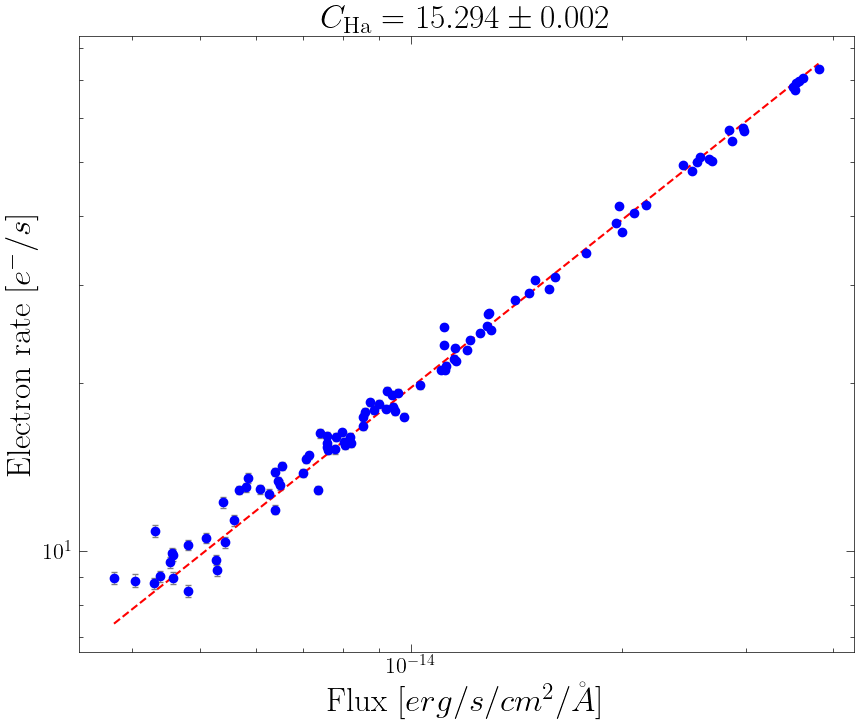

In [24]:
truefluxes_Ha = Compute_All_Fluxes_in_Filter(datalink, 'Ha')

C_Ha, C_err_Ha = Fit_Fluxes(truefluxes_Ha, ourfluxes_Ha, ourfluxes_Ha_err, 'Ha')

C:\Users\marco\AppData\Local\Temp\ipykernel_5676\63975556.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  denominator, error = quad(lambda w: f_transmission(w), min_wavelength, max_wavelength)



spectrum wavelength in (3360, 10200) 	 filter wavelength in (4714, 5068)
The integrals are performed over the filter domain.


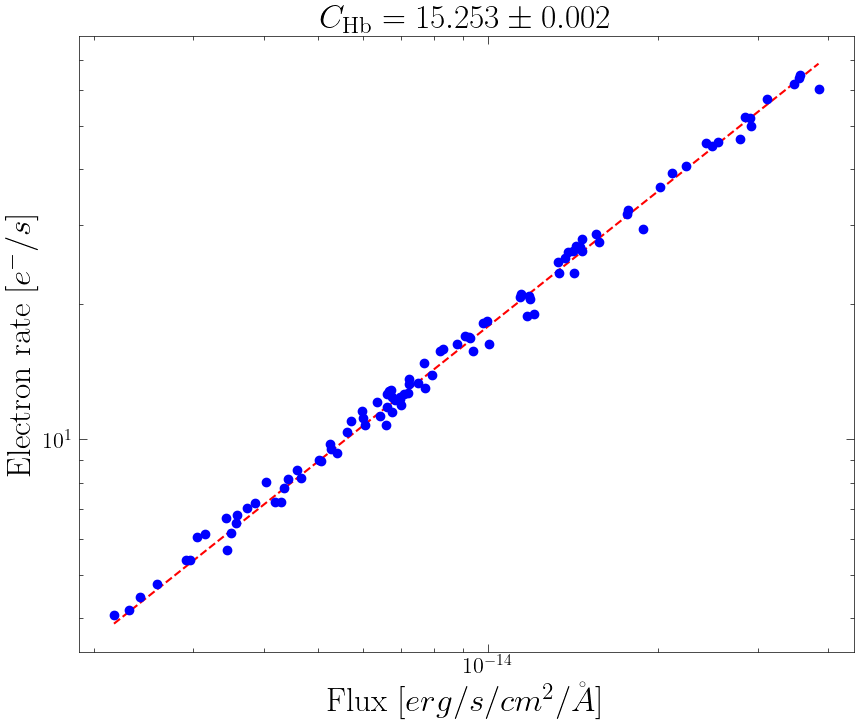

In [25]:
truefluxes_Hb = Compute_All_Fluxes_in_Filter(datalink, 'Hb')

C_Hb, C_err_Hb = Fit_Fluxes(truefluxes_Hb, ourfluxes_Hb, ourfluxes_Hb_err, 'Hb')

C:\Users\marco\AppData\Local\Temp\ipykernel_5676\63975556.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  denominator, error = quad(lambda w: f_transmission(w), min_wavelength, max_wavelength)



spectrum wavelength in (3360, 10200) 	 filter wavelength in (3890, 5890)
The integrals are performed over the filter domain.


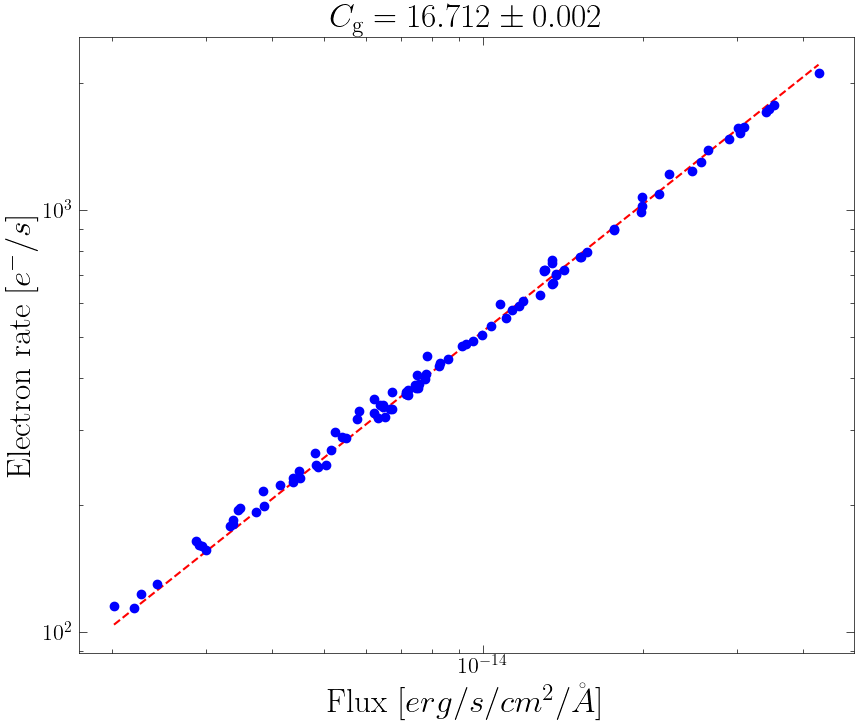

In [26]:
truefluxes_g = Compute_All_Fluxes_in_Filter(datalink, 'g')

C_g, C_err_g = Fit_Fluxes(truefluxes_g, ourfluxes_g, ourfluxes_g_err, 'g')

C:\Users\marco\AppData\Local\Temp\ipykernel_5676\63975556.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  denominator, error = quad(lambda w: f_transmission(w), min_wavelength, max_wavelength)



spectrum wavelength in (3360, 10200) 	 filter wavelength in (5380, 7170)
The integrals are performed over the filter domain.


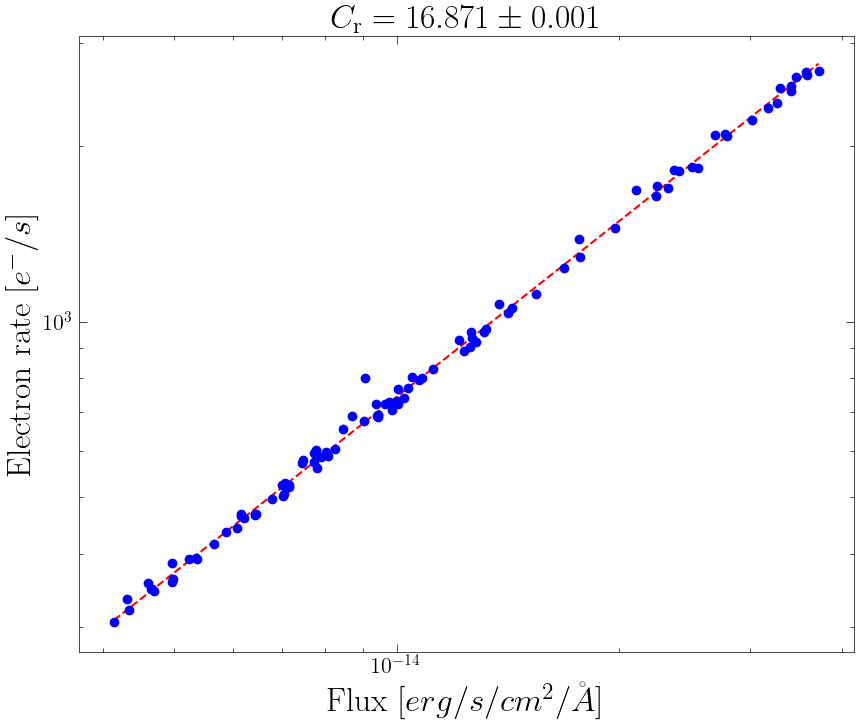

In [27]:
truefluxes_r = Compute_All_Fluxes_in_Filter(datalink, 'r')

C_r, C_err_r = Fit_Fluxes(truefluxes_r, ourfluxes_r, ourfluxes_r_err, 'r')

C:\Users\marco\AppData\Local\Temp\ipykernel_5676\63975556.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  denominator, error = quad(lambda w: f_transmission(w), min_wavelength, max_wavelength)



spectrum wavelength in (3360, 10200) 	 filter wavelength in (6690, 8720)
The integrals are performed over the filter domain.


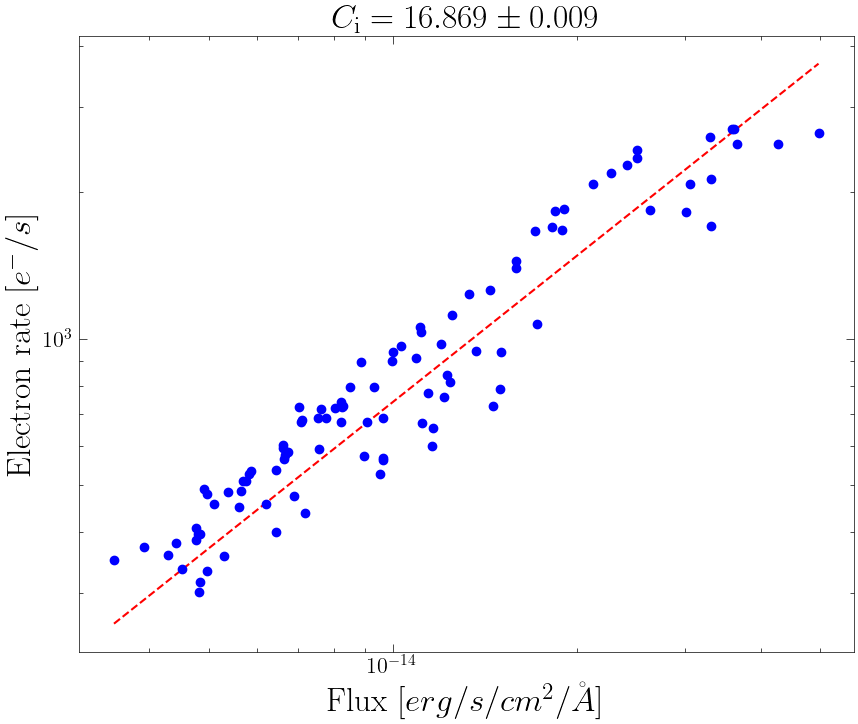

In [28]:
truefluxes_i = Compute_All_Fluxes_in_Filter(datalink, 'i')

C_i, C_err_i = Fit_Fluxes(truefluxes_i, ourfluxes_i, ourfluxes_i_err, 'i')

In [29]:
# Comparison with the tabulated values
print(C_Ha - 16.58)
print(C_Hb - 16.06)
print(C_g - 17.61)
print(C_r - 18.12)
print(C_i - 18.08)

-1.2860504097147878
-0.8073153174548295
-0.897525715834206
-1.248631160554627
-1.2105520321114334


## <font color='red'>We are 1 orders of magnitude off<font>

<font color='red'>Error estimation should be refined by considering:<font>

$$\text{Image}_\text{final} = \text{Image}_\text{raw} - \text{Image}_\text{background} \:\:\: \Longrightarrow \:\:\: \sigma_\text{final} = \sqrt{\sigma_\text{raw}^2 + \sigma_\text{background}^2} \:\:\: \text{for each pixel}$$

$$\sigma_\text{aperture} = \sqrt{\sum_\text{aperture} \sigma_\text{pixel in aperture}^2}$$

# Science?

$ \mathrm{flux}_{\mathrm{H}\alpha}/\mathrm{flux}_{\mathrm{H}\beta} \approx 2.86^{+0.18}_{-0.11} $

$D = \frac{f_{\mathrm{H}\alpha}}{f_{\mathrm{H}\beta}} - 2.9 = (R_\alpha / R_\beta) 10^{-0.4(ZP_{\alpha} - ZP_{\beta})} - 2.9$  Minimo X>0.2 perché abbia qualche senso

Area nebulosa divisa in 3000 sezioni da 180 pixel, per noi sarebbero circa 450 pixel per sezione (Binning 0.0167 × 0.0167 × 0.0167 dex^3 ?)

https://www.aanda.org/articles/aa/full_html/2023/02/aa45072-22/aa45072-22.html